In [1]:
import modelling_lib_rodrixx as mod
import preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1980_to_2021.pkl'))

In [4]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,1,Kareem Abdul-Jabbar,C,32,LAL,82,-10,38.3,10.2,16.9,...,7,2,1,0.732,82,2,1.000,147,0.665,221
1,2,Tom Abernethy,PF,25,GSW,67,-10,18.2,2.3,4.7,...,32,54,41,0.293,82,44,0.817,0,0.000,221
2,3,Alvan Adams,C,25,PHO,75,-10,28.9,6.2,11.7,...,11,12,12,0.671,82,6,0.915,0,0.000,221
3,4,Tiny Archibald,PG,31,BOS,80,80,35.8,4.8,9.9,...,33,31,20,0.744,82,1,0.976,2,0.009,221
4,5,Dennis Awtrey,C,31,CHI,26,-10,21.5,1.0,2.3,...,21,56,42,0.366,82,38,0.317,0,0.000,221


In [5]:
cols_to_drop = ['Rk', 'GT', 'Votes', 'MaxVotes', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos']
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
cols_to_ohe = ['Pos', 'Tm']

In [6]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [7]:
df = pipe_clean.fit_transform(df)

In [8]:
df.head()

,,Age,G,GS,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,...,WS_rank,WS/48_rank,OBPM_rank,DBPM_rank,BPM_rank,VORP_rank,%W,%W_rank,%G,Share
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1980,32,82,-10,38.3,10.2,16.9,0.604,0.0,0.0,0.000,...,1,1,5,7,2,1,0.732,2,1.000,0.665
2,1980,25,67,-10,18.2,2.3,4.7,0.481,0.0,0.0,0.000,...,71,83,50,32,54,41,0.293,44,0.817,0.000
3,1980,25,75,-10,28.9,6.2,11.7,0.531,0.0,0.0,0.000,...,27,21,23,11,12,12,0.671,6,0.915,0.000
4,1980,31,80,80,35.8,4.8,9.9,0.482,0.1,0.2,0.222,...,14,25,26,33,31,20,0.744,1,0.976,0.009
5,1980,31,26,-10,21.5,1.0,2.3,0.450,0.0,0.0,0.000,...,85,109,63,21,56,42,0.366,38,0.317,0.000


In [9]:
len(df[df.index.get_level_values(1) > 2015]) / len(df)

0.17507805847289243

In [10]:
val_df = df[df.index.get_level_values(1) > 2015]
dev_df = df[df.index.get_level_values(1) <= 2015]

In [11]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .3)

In [12]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [13]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [14]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [15]:
# pipe_scale = Pipeline(steps = [
#     ('Scaler', scaler),
#     ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
# ])

In [16]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [17]:
mlflow.set_experiment('NBA MVP prediction Random Forest')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/4', experiment_id='4', lifecycle_stage='active', name='NBA MVP prediction Random Forest', tags={}>

In [27]:
param_grid = {
    'max_depth': [8], 
    'min_samples_split': [10],
    'max_features': [.5],
    'n_estimators': [200]
    }

In [28]:
with mlflow.start_run():
    estimator = RandomForestRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_rf(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=200; total time= 1.5min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=200; total time= 1.4min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=200; total time= 1.4min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=200; total time= 1.4min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=200; total time= 1.8min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=200; total time= 1.5min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=200; total time= 1.4min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=200; total time= 1.4min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=200; total time= 1.5min
[CV] END max_depth=8, max_features=0.5, min_samp

2022/08/03 21:04:36 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\marcr\AppData\Local\Temp\tmpip6hwun1\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


In [29]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.013026,0.015726,0.029513
R2,0.991182,0.974478,0.727982


In [30]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

In [31]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
105,2016,Stephen Curry,1.000,0.896358
263,2016,Kawhi Leonard,0.484,0.277899
222,2016,LeBron James,0.482,0.279554
452,2016,Russell Westbrook,0.371,0.248517
126,2016,Kevin Durant,0.112,0.462736
348,2016,Chris Paul,0.082,0.077477
167,2016,Draymond Green,0.038,0.090056
266,2016,Damian Lillard,0.020,0.022674
178,2016,James Harden,0.007,0.180089


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.294950
173,2017,James Harden,0.746,0.478917
261,2017,Kawhi Leonard,0.495,0.535448
221,2017,LeBron James,0.330,0.238871
425,2017,Isaiah Thomas,0.080,0.186201
98,2017,Stephen Curry,0.051,0.284432
16,2017,Giannis Antetokounmpo,0.007,0.095606
453,2017,John Wall,0.007,0.091503
100,2017,Anthony Davis,0.002,0.136986


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.748071
249,2018,LeBron James,0.731,0.370903
122,2018,Anthony Davis,0.441,0.204696
298,2018,Damian Lillard,0.205,0.171697
508,2018,Russell Westbrook,0.075,0.200821
16,2018,Giannis Antetokounmpo,0.074,0.131203
143,2018,Kevin Durant,0.065,0.231374
130,2018,DeMar DeRozan,0.032,0.021998
7,2018,LaMarcus Aldridge,0.006,0.054849


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.665678
207,2019,James Harden,0.768,0.575295
184,2019,Paul George,0.352,0.099219
270,2019,Nikola Jokić,0.210,0.116699
124,2019,Stephen Curry,0.173,0.165934
305,2019,Damian Lillard,0.068,0.129536
155,2019,Joel Embiid,0.049,0.073672
150,2019,Kevin Durant,0.025,0.188427
301,2019,Kawhi Leonard,0.013,0.193494


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.619503
251,2020,LeBron James,0.746,0.369397
199,2020,James Harden,0.363,0.392589
134,2020,Luka Dončić,0.198,0.179868
294,2020,Kawhi Leonard,0.166,0.145313
123,2020,Anthony Davis,0.081,0.264946
396,2020,Chris Paul,0.026,0.015935
297,2020,Damian Lillard,0.023,0.163441
262,2020,Nikola Jokić,0.018,0.049662


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.539398
146,2021,Joel Embiid,0.580,0.129370
116,2021,Stephen Curry,0.449,0.201333
12,2021,Giannis Antetokounmpo,0.345,0.232400
396,2021,Chris Paul,0.138,0.044737
130,2021,Luka Dončić,0.042,0.177315
297,2021,Damian Lillard,0.038,0.215972
421,2021,Julius Randle,0.020,0.026475
439,2021,Derrick Rose,0.010,0.000219


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
1,2016,Quincy Acy,0.0,0.000219
2,2016,Jordan Adams,0.0,0.010897
3,2016,Steven Adams,0.0,0.000222
4,2016,Arron Afflalo,0.0,0.000230
5,2016,Alexis Ajinça,0.0,0.000219
...,...,...,...,...
536,2021,Delon Wright,0.0,0.000219
537,2021,Thaddeus Young,0.0,0.000250
538,2021,Trae Young,0.0,0.038623


In [32]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
453,2016,Hassan Whiteside,0.0,0.110713
66,2017,Jimmy Butler,0.0,0.131006
90,2017,DeMarcus Cousins,0.0,0.123202
156,2017,Rudy Gobert,0.0,0.209086
434,2017,Karl-Anthony Towns,0.0,0.131264
484,2018,Karl-Anthony Towns,0.0,0.111393
481,2019,Karl-Anthony Towns,0.0,0.128656
493,2019,Nikola Vučević,0.0,0.111745
35,2020,Bradley Beal,0.0,0.103849


<AxesSubplot:title={'center':'Most important features'}, xlabel='Feature', ylabel='Importance coefficient'>

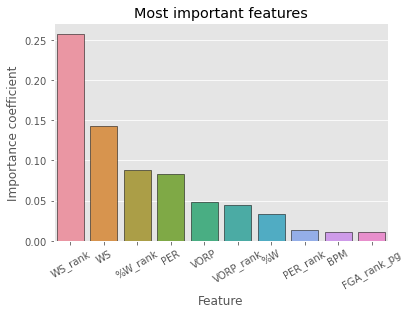

In [33]:
mod.display_feature_importances(best_model)

In [34]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

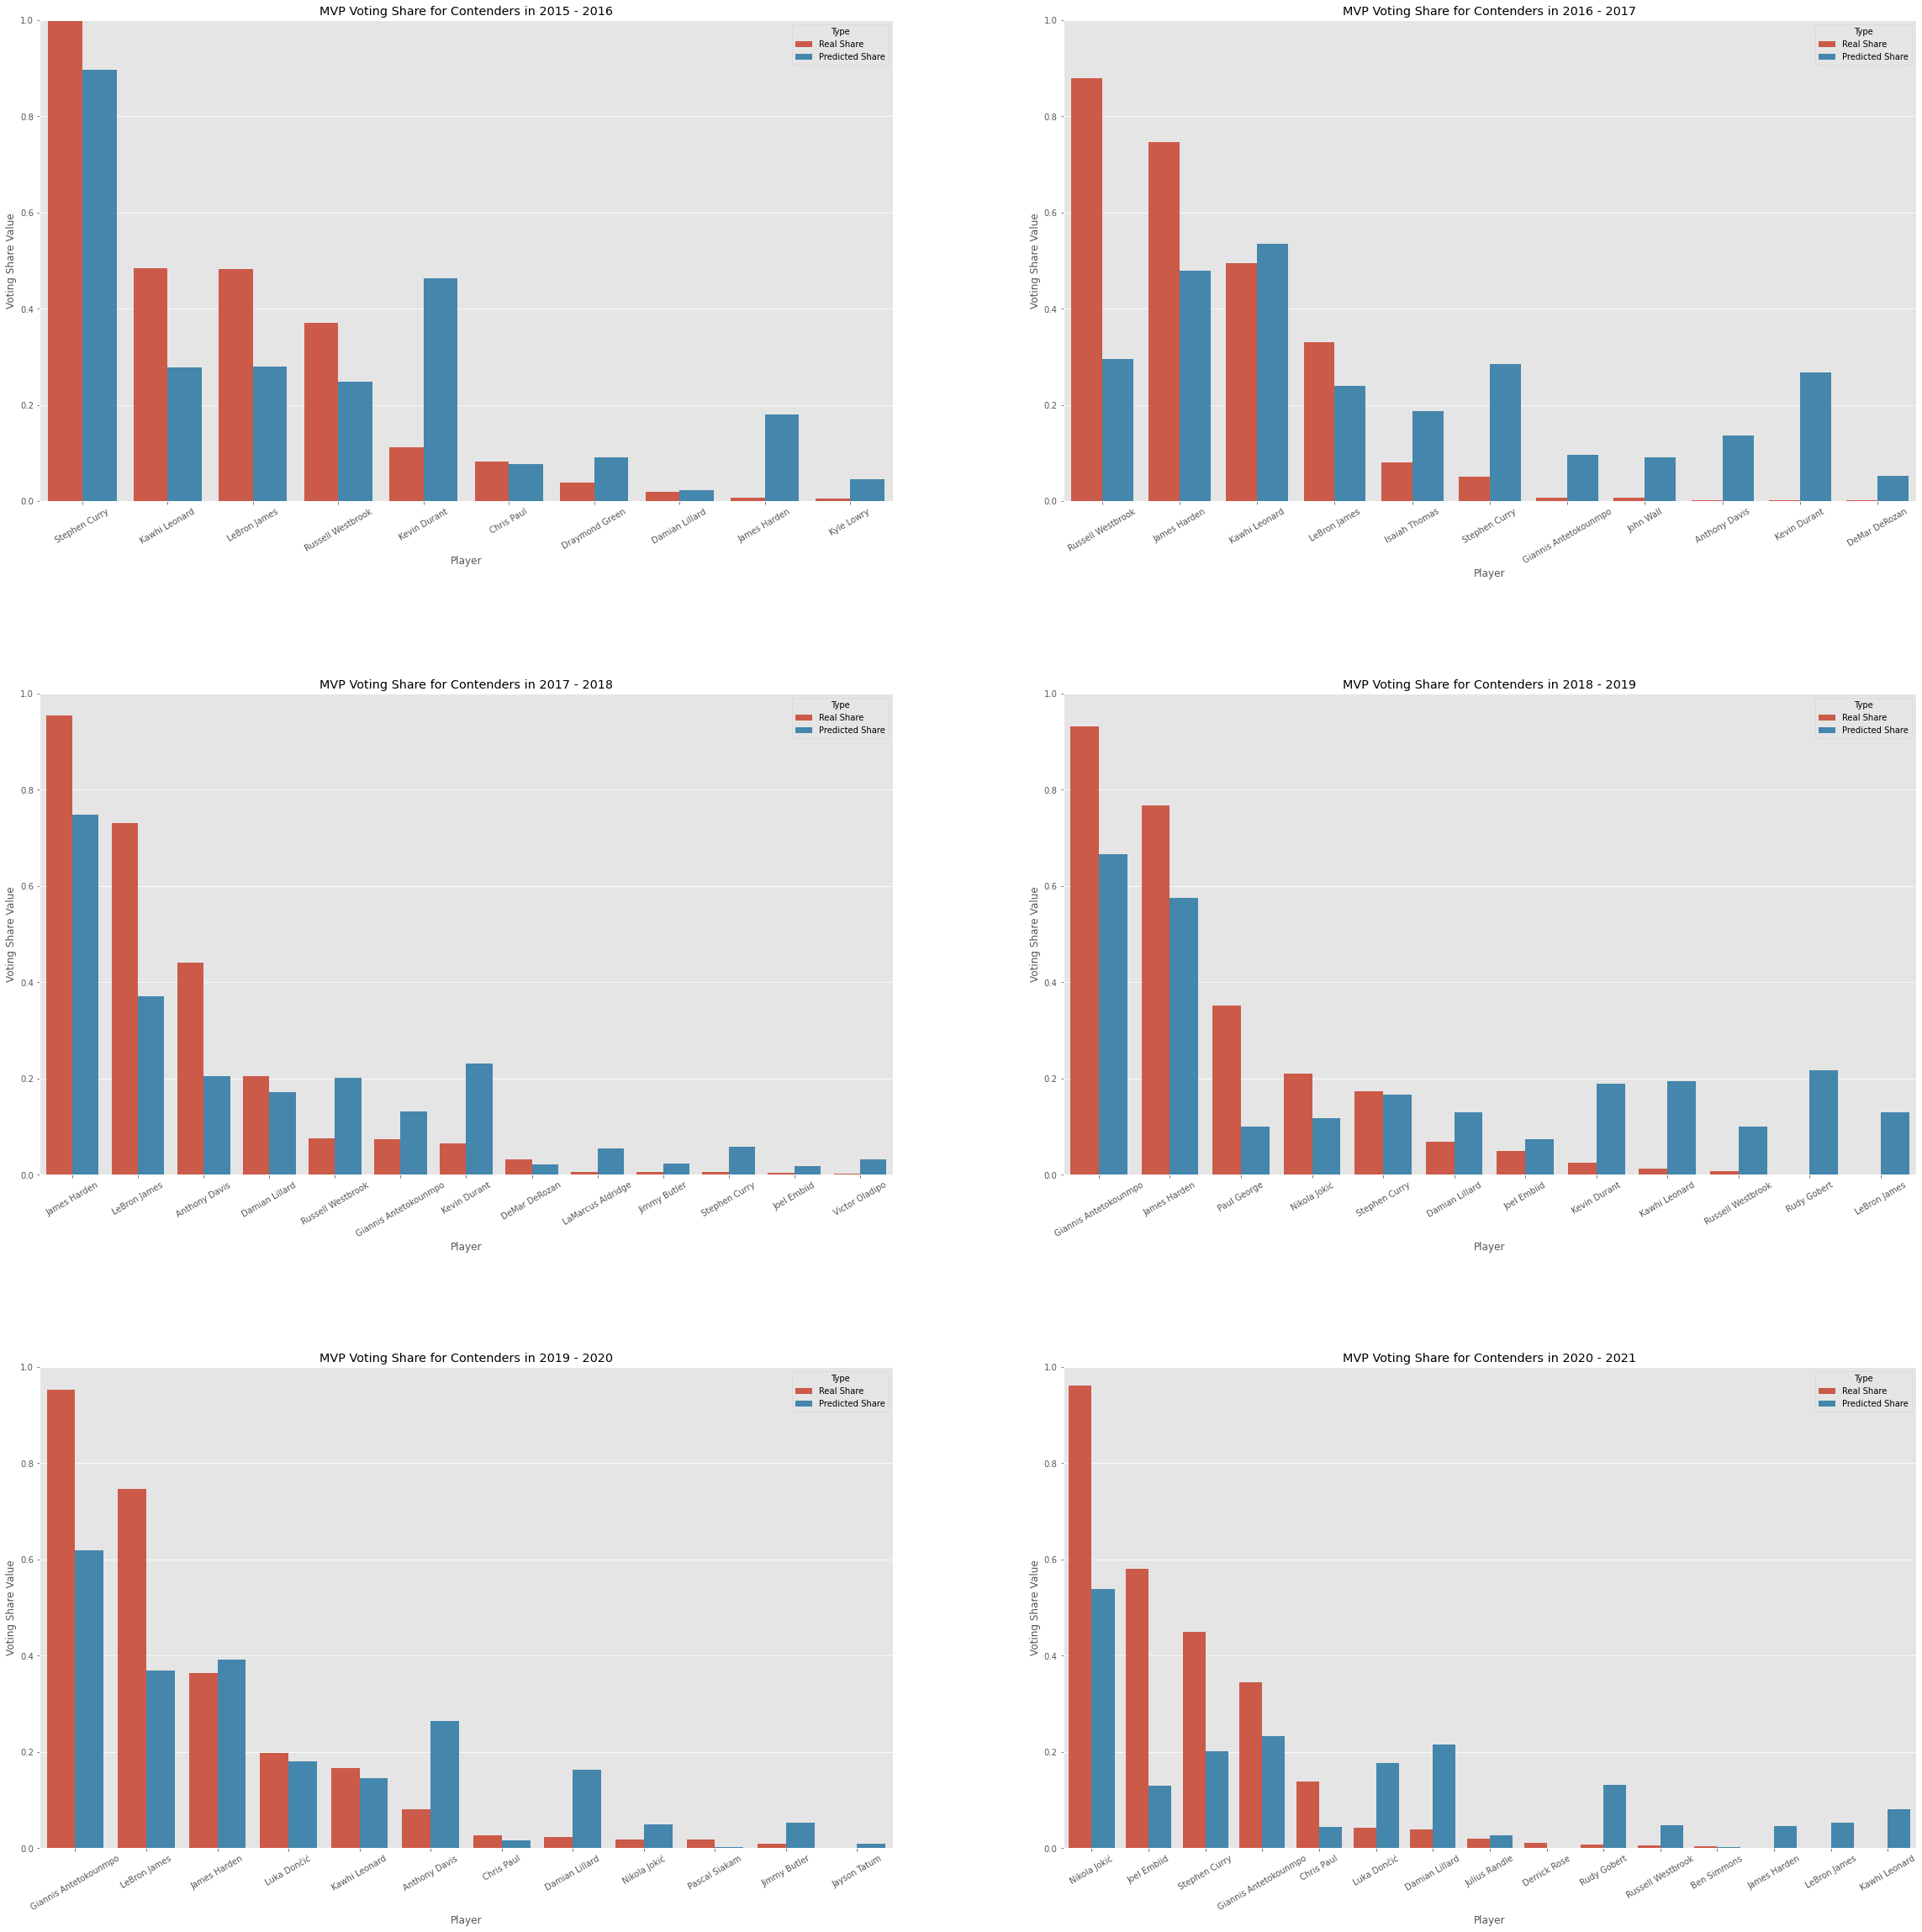

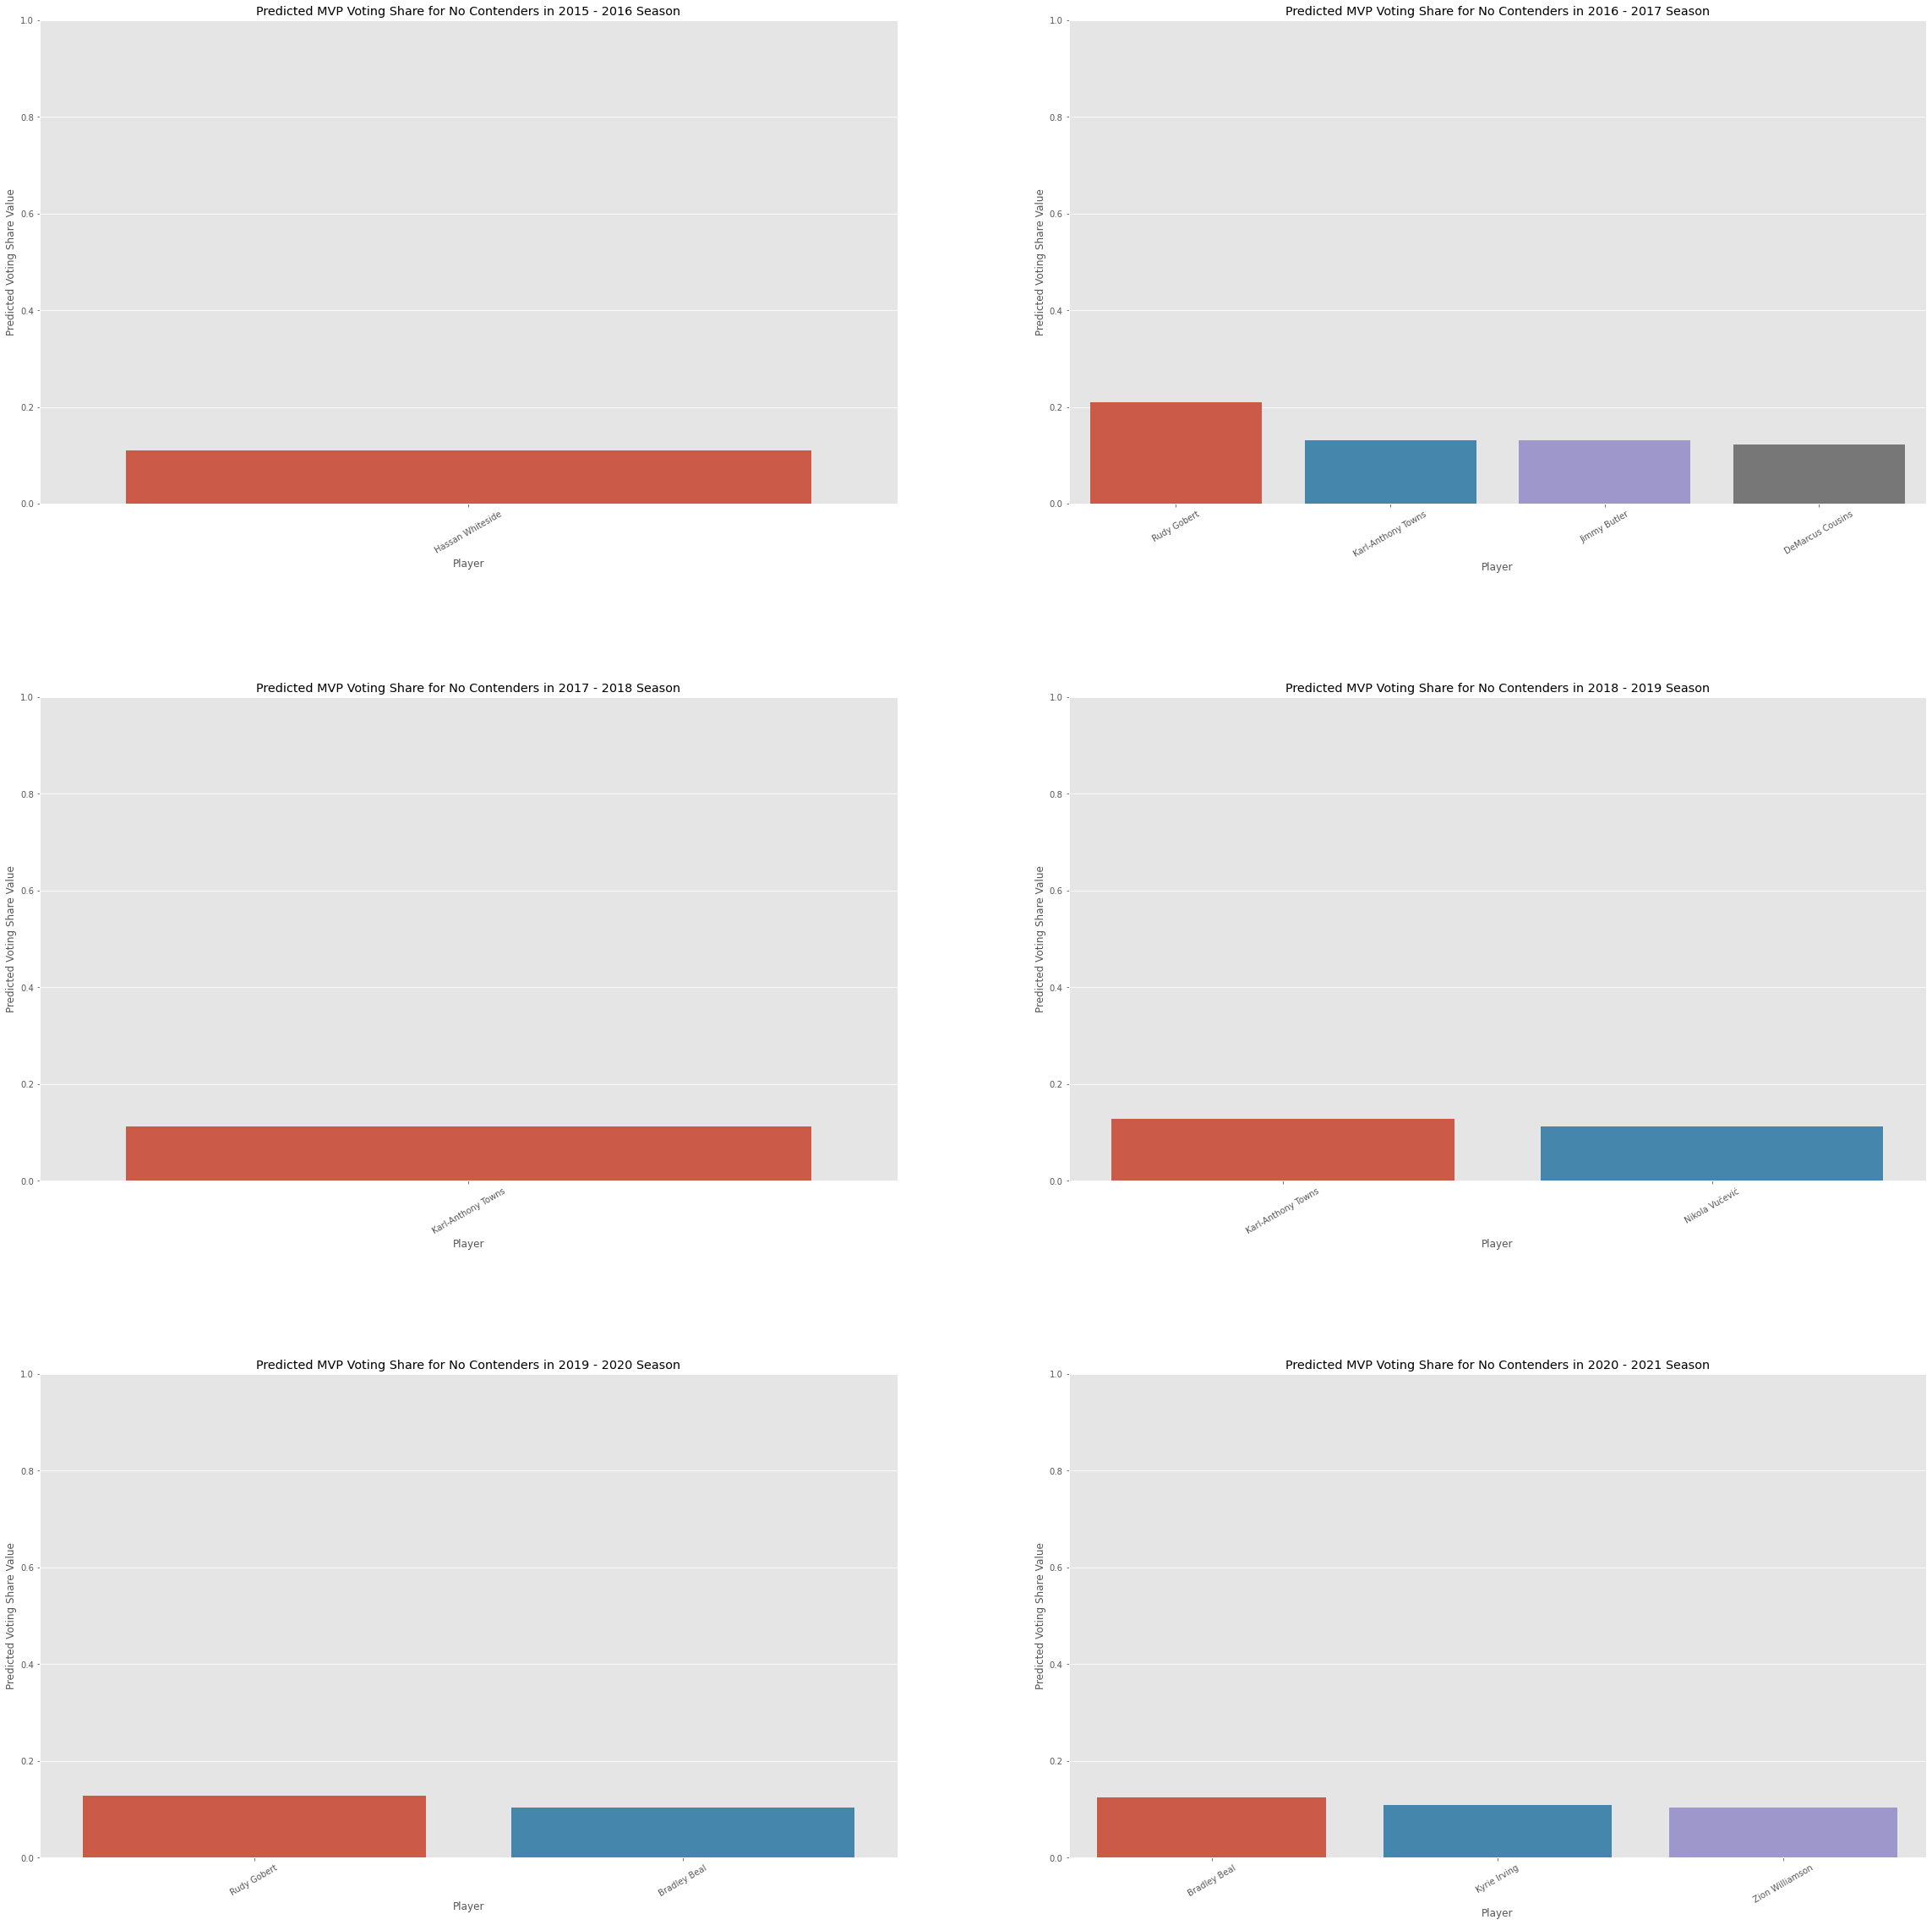

In [35]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)